# Spark Lab Session, 27/04/20

# 1 - Initialize the environment

In [1]:
sc # this should print Spark Context, if it does not, shut down all your kernels
# (for this go back to dashboard -> running and shutdown kernel by kernel)

<SparkContext master=local[4] appName=PySparkShell>

# 2 - Playing with RDDs

## 2.1 Compute the RDD containing the set $L$ of integers, with $L = \{ 0 ... 2999 \}$

In [2]:
from operator import add

In [3]:
l=range(3000)
d1= sc.parallelize(l)
d1.reduce(add)

4498500

In [4]:
d1.take(5)

[0, 1, 2, 3, 4]

## 2.2 Compute RDD containing the set $C = \{ x^3 | x ∈ L \}$

In [5]:
c=d1.map(lambda x: x**3)

In [6]:
c.take(5)

[0, 1, 8, 27, 64]

### Compute the sum of elements in $C$ (i.e. $\Sigma_{x\in C} x$).

In [7]:
c.reduce(add)

20236502250000

## 2.3 What is the repartition for the last digits of integers in C? i.e. how many end with a 0? with a 1? etc.

DO: Compute an RDD containing a set of pairs (0, v0), . . . ,(9, v9) where vi
is the number of integers in C
having i for last digit.
The last digit of an integer i can be computed using (i%10).

In [8]:
def last_digit(i): #returns the last digit of the positive integer i
    return i%10

In [9]:
v=c.map(lambda x : last_digit(x))
vr=v.map(lambda x : (x,1))
for k, v in vr.groupByKey().mapValues(lambda x:sum(x)).sortByKey().collect():
    print(k,v)

0 300
1 300
2 300
3 300
4 300
5 300
6 300
7 300
8 300
9 300


In [10]:
for k, v in vr.reduceByKey(add).sortByKey().collect():
    print(k,v)

0 300
1 300
2 300
3 300
4 300
5 300
6 300
7 300
8 300
9 300


## 2.4 What is the repartition of digits for the integers in C?

In [11]:
def digits(i): #return the list of digits of the positive integer i
    return list(str(i))

In [12]:
dig=c.flatMap(lambda x : digits(x))
dig=dig.map(lambda x: (int(x),1))
for k, v in dig.reduceByKey(add).sortByKey().collect():
    print(k,v)

0 3127
1 3667
2 3294
3 2814
4 2762
5 2653
6 2713
7 2787
8 2639
9 2521


In [13]:
dig.take(5)

[(0, 1), (1, 1), (8, 1), (2, 1), (7, 1)]

In [14]:
# import functools
# import operator
# cols_feat_flat=functools.reduce(operator.concat, cols_feat)
# uniq_feat=np.unique(cols_feat_flat)
# len(uniq_feat)

# 3 - Computation of $\pi$

To compute the value of $\pi$, you will generate the list of all pairs (x,y) of integers from $0$ to $K-1$. Then you will compute the number of such pairs such that $x^2+y^2\leq K$. The ratio between the number of such pairs and the number of total pairs is an approximation of $\pi$.
For $K=3000$ you should obtain a value close to 3.1416.

## 3.1 compute the set of  $\{ (x,y) | 0 \leq x,y \leq K \}$

In [15]:
k=3000
l1=range(k)
rdd=sc.parallelize(l1)
rddPi=rdd.cartesian(rdd)

In [16]:
rddPi.take(5)

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]

## 3.2 compute the number of pairs such that $x^2+y^2\leq K$

In [17]:
rddPi=rddPi.map(lambda x: ((2*x[0]+1)**2,(2*x[1]+1)**2))
rddPi2=rddPi.map(lambda x: (x[0],x[1],x[0]+x[1]))

filterPi=rddPi2.filter(lambda x: x[2]<=(2*k)**2)
print(filterPi.take(5))

nbFilter=filterPi.count()
nbFilter

[(1, 1, 2), (1, 9, 10), (1, 25, 26), (1, 49, 50), (1, 81, 82)]


7068585

## 3.3 What is your approximation of $\pi$ ?

In [18]:
nbPairs=k**2
print(nbPairs)
# allPairs=pi2.count()

pi=4*nbFilter/nbPairs
pi

9000000


3.1415933333333332

# 4 - Playing with the movie Lens dataset
## 4.1 Readings files into RDD

In [19]:
# path=r"C:\Users\Hanane\Documents\Python_Scripts\TelecomParis\Module_11_Calcul_Disribue\ml-latest-small"

In [20]:
import re
future_pattern = re.compile("""([^,"]+|"[^"]+")(?=,|$)""")

def parseCSV(line):
     return future_pattern.findall(line)

#ratingsFile = sc.textFile("hdfs:///datasets/movielens/ratings.csv").map(parseCSV)
#moviesFile = sc.textFile("hdfs:///datasets/movielens/movies.csv").map(parseCSV)


# For your tests I propose that you start with these smaller datasets
# 
ratingsFile = sc.textFile("hdfs:///datasets/movie_small/ratings.csv").map(parseCSV)
moviesFile = sc.textFile("hdfs:///datasets/movie_small/movies.csv").map(parseCSV)

# ratingsFile = sc.textFile(path+"//ratings.csv").map(parseCSV)
# moviesFile = sc.textFile(path+"//movies.csv").map(parseCSV)

### 4.2 Check-out what is the data in your RDD

In [21]:
ratingsFile.take(4)

[['userId', 'movieId', 'rating', 'timestamp'],
 ['1', '1', '4.0', '964982703'],
 ['1', '3', '4.0', '964981247'],
 ['1', '6', '4.0', '964982224']]

In [22]:
moviesFile.take(4)

[['movieId', 'title', 'genres'],
 ['1', 'Toy Story (1995)', 'Adventure|Animation|Children|Comedy|Fantasy'],
 ['2', 'Jumanji (1995)', 'Adventure|Children|Fantasy'],
 ['3', 'Grumpier Old Men (1995)', 'Comedy|Romance']]

## 4.3 Cleaning data: find a way to discard the first line

Both RDDs (ratingsFile and moviesFile) contain the data from the CSV and columns have been split,
however the data is still raw : all fields are strings and the header of the dataset is still here.
DO: Using filter and map remove the header of the CSV file and cast the third column of ratingsFile
to float create an RDD containing the ratings and movies

In [23]:
headerR = ratingsFile.first() #extract header
ratings = ratingsFile.filter(lambda row: row != headerR) 

ratings.take(5)

[['1', '1', '4.0', '964982703'],
 ['1', '3', '4.0', '964981247'],
 ['1', '6', '4.0', '964982224'],
 ['1', '47', '5.0', '964983815'],
 ['1', '50', '5.0', '964982931']]

In [95]:
headerM = moviesFile.first() #extract header
movies = moviesFile.filter(lambda row: row != headerM) 
movies.take(5)

[['1', 'Toy Story (1995)', 'Adventure|Animation|Children|Comedy|Fantasy'],
 ['2', 'Jumanji (1995)', 'Adventure|Children|Fantasy'],
 ['3', 'Grumpier Old Men (1995)', 'Comedy|Romance'],
 ['4', 'Waiting to Exhale (1995)', 'Comedy|Drama|Romance'],
 ['5', 'Father of the Bride Part II (1995)', 'Comedy']]

##### Converting the note from string to float

In [25]:
def cols_change(col):
    for i,elem in enumerate(col):
        if i==2:
            col[i]=float(elem)
    return col

In [26]:
# ratings=ratings.map(lambda x : [x[0],x[1],float(x[2]),x[3]])
# ratings=ratings.map(lambda x : [float(x[i]) for i,value in enumerate(x) if i=2])
ratings=ratings.map(lambda x : cols_change(x))
ratings.take(4)

[['1', '1', 4.0, '964982703'],
 ['1', '3', 4.0, '964981247'],
 ['1', '6', 4.0, '964982224'],
 ['1', '47', 5.0, '964983815']]

##### create an RDD containing the ratings and movies

In [108]:
ratings.map(lambda x: (x[1],(x[0],x[2]))).join(movies.map(lambda x:(x[0],x[1]))).take(5)
#movieId, (userId,rating) & movieId,movieName ==> after join movieId,((userId,rating),name)

[('50', (('1', 5.0), '"Usual Suspects, The (1995)"')),
 ('50', (('5', 4.0), '"Usual Suspects, The (1995)"')),
 ('50', (('6', 1.0), '"Usual Suspects, The (1995)"')),
 ('50', (('7', 4.5), '"Usual Suspects, The (1995)"')),
 ('50', (('8', 5.0), '"Usual Suspects, The (1995)"'))]

## 4.4 Compute the 10 best rated movies 
 1. sum(ratings)/numberOfRatings

DO: Compute the 10 movieId that have the best average rating. Hint : use sortBy and take to select the best
movies

lesson
Input.map(lambda x: (x[0],(x[1],1))).reduceByKey(lambda x,y: (x[0]+y[0],x[1]+y[1]) ).mapValues(lambda x: x[0]/x[1]).collect()
Input.groupByKey().mapValues(average).collect()

In [27]:
ratings.take(4) #['userId', 'movieId', 'rating', 'timestamp'],

[['1', '1', 4.0, '964982703'],
 ['1', '3', 4.0, '964981247'],
 ['1', '6', 4.0, '964982224'],
 ['1', '47', 5.0, '964983815']]

##### Build an rdd with only the userId and the note

In [28]:
ratingsAvg=ratings.map(lambda x:(x[1],x[2])) #'movieId', 'rating'
ratingsAvg.take(5)

[('1', 4.0), ('3', 4.0), ('6', 4.0), ('47', 5.0), ('50', 5.0)]

### 1st method

In [29]:
ratingsMethod1=ratingsAvg.groupByKey().mapValues(lambda l: sum(l)/len(l)).sortBy(lambda x : x[1],ascending=False)
ratingsMethod1.take(5)

[('6835', 5.0), ('1151', 5.0), ('1631', 5.0), ('102217', 5.0), ('27523', 5.0)]

In [30]:
topMovies=ratingsMethod1.take(10)
topMovies

[('6835', 5.0),
 ('1151', 5.0),
 ('1631', 5.0),
 ('102217', 5.0),
 ('27523', 5.0),
 ('53', 5.0),
 ('1140', 5.0),
 ('8238', 5.0),
 ('47736', 5.0),
 ('53355', 5.0)]

### Method 1 bis

In [31]:
ratingsAvg.map(lambda x: (x[0],(x[1],1))).reduceByKey(lambda x,y: (x[0]+y[0],x[1]+y[1]) ).mapValues(lambda x: x[0]/x[1]).sortBy(lambda x : x[1],ascending=False).take(5)

[('6835', 5.0), ('1151', 5.0), ('1631', 5.0), ('102217', 5.0), ('27523', 5.0)]

##  4.5 Compute the name of these movies

##### Get only the columns we want movieID and the name

In [32]:
moviesCalc=movies.map(lambda x: (x[0],x[1]))
moviesCalc.take(5)

[('1', 'Toy Story (1995)'),
 ('2', 'Jumanji (1995)'),
 ('3', 'Grumpier Old Men (1995)'),
 ('4', 'Waiting to Exhale (1995)'),
 ('5', 'Father of the Bride Part II (1995)')]

##### Replace " and ' in the biginning of the title by nothing to be able to sort correctly

In [33]:
def rep(s):
    for r in (("\"", ""), ("'", "")):
        s = s.replace(*r)
    return s

In [34]:
# moviesBest=moviesBest.map(lambda x: (x[0],x[1][0].replace("\"","")+x[1][1:]))
moviesCalc=moviesCalc.map(lambda x: (x[0],rep(x[1][0]) + x[1][1:]))#.collect()

##### Join

In [35]:
# ratingsBest.join(moviesBest).collect()
ratingsMethod1.join(moviesCalc).take(10)

[('1151', (5.0, 'Lesson Faust (1994)')),
 ('102217', (5.0, 'Bill Hicks: Revelations (1993)')),
 ('27523', (5.0, 'My Sassy Girl (Yeopgijeogin geunyeo) (2001)')),
 ('53', (5.0, 'Lamerica (1994)')),
 ('53578', (5.0, 'Valet, The (La doublure) (2006)"')),
 ('60737', (5.0, 'Watching the Detectives (2007)')),
 ('83969', (5.0, 'Down Argentine Way (1940)')),
 ('96608', (5.0, 'Runaway Brain (1995) ')),
 ('107951', (5.0, 'Hunting Elephants (2013)')),
 ('109241',
  (5.0, "On the Other Side of the Tracks (De l'autre côté du périph) (2012)"))]

In [36]:
bestMovies=ratingsMethod1.join(moviesCalc).sortBy(lambda x: (-x[1][0],x[1][1]), ascending=True)
bestMovies.take(10)

[('77846', (5.0, '12 Angry Men (1997)')),
 ('141816', (5.0, '12 Chairs (1976)')),
 ('5468', (5.0, '20 Million Miles to Earth (1957)')),
 ('27373', (5.0, '61* (2001)')),
 ('42556', (5.0, '7 Faces of Dr. Lao (1964)')),
 ('44943', (5.0, '9/11 (2002)')),
 ('172875', (5.0, 'A Detective Story (2003)')),
 ('126088', (5.0, 'A Flintstones Christmas Carol (1994)')),
 ('147410', (5.0, 'A Perfect Day (2015)')),
 ('170597', (5.0, 'A Plasticine Crow (1981)'))]

## 4.6 A better ordering
Try the following functions to determine the average ratings:
 2. sum(ratings)/(1+numberOfRatings)
 3. sum(ratings)/max(20,numberOfRatings)

In [37]:
def joinBestMovies(leftRdd,rightRdd):
    ratedMovies=leftRdd.join(rightRdd).sortBy(lambda x: (-x[1][0],x[1][1]), ascending=True)
    bestMovies=ratedMovies.take(10)
    return bestMovies

##### Using Method2

grade(m) = Sum(Pr∈ratings(m) r)/( |ratings(m)|+ 1)

In [38]:
ratingsMethod2=ratingsAvg.groupByKey().mapValues(lambda l: sum(l)/(len(l)+1)).sortBy(lambda x : x[1],ascending=False)
joinBestMovies(ratingsMethod2,moviesCalc)

[('318', (4.415094339622642, 'Shawshank Redemption, The (1994)"')),
 ('858', (4.266839378238342, 'Godfather, The (1972)"')),
 ('1104', (4.261904761904762, 'Streetcar Named Desire, A (1951)"')),
 ('2959', (4.2534246575342465, 'Fight Club (1999)')),
 ('1221', (4.226923076923077, 'Godfather: Part II, The (1974)"')),
 ('750',
  (4.224489795918367,
   'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)')),
 ('177593',
  (4.222222222222222, 'Three Billboards Outside Ebbing, Missouri (2017)"')),
 ('50', (4.217073170731707, 'Usual Suspects, The (1995)"')),
 ('1213', (4.216535433070866, 'Goodfellas (1990)')),
 ('260', (4.214285714285714, 'Star Wars: Episode IV - A New Hope (1977)'))]

##### Using method 3 from the notebook (max(20,...)

sum(ratings)/max(20,numberOfRatings)

In [114]:
ratingsAvg.take(7)

[('1', 4.0),
 ('3', 4.0),
 ('6', 4.0),
 ('47', 5.0),
 ('50', 5.0),
 ('70', 3.0),
 ('101', 5.0)]

In [112]:
ratingsMethod3nb=ratingsAvg.groupByKey().mapValues(lambda l: sum(l)/max(20,len(l))).sortBy(lambda x : x[1],ascending=False)
joinBestMovies(ratingsMethod3nb,moviesCalc) # dans cette méthode, pour rappel, l'ordre se fait sur le rating descending, et le nom ascending

[('1104', (4.475, 'Streetcar Named Desire, A (1951)"')),
 ('318', (4.429022082018927, 'Shawshank Redemption, The (1994)"')),
 ('922', (4.333333333333333, 'Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)')),
 ('898', (4.310344827586207, 'Philadelphia Story, The (1940)"')),
 ('475', (4.3, 'In the Name of the Father (1993)')),
 ('1204', (4.3, 'Lawrence of Arabia (1962)')),
 ('246', (4.293103448275862, 'Hoop Dreams (1994)')),
 ('858', (4.2890625, 'Godfather, The (1972)"')),
 ('1235', (4.288461538461538, 'Harold and Maude (1971)')),
 ('168252', (4.28, 'Logan (2017)'))]

##### Using method 3 from the pdf

grade(m) =[Sum(Pr∈ratings(m) r)/|ratings(m)|] ×log(1 +|ratings(m)|)

In [40]:
from math import log

In [41]:
ratingsMethod3pdf=ratingsAvg.groupByKey().mapValues(lambda l: (sum(l)/len(l))*log(1+len(l))).sortBy(lambda x : x[1],ascending=False)
joinBestMovies(ratingsMethod3pdf,moviesCalc)

[('318', (25.5202528120611, 'Shawshank Redemption, The (1994)"')),
 ('356', (24.148197375717082, 'Forrest Gump (1994)')),
 ('296', (24.049620750363033, 'Pulp Fiction (1994)')),
 ('2571', (23.608551552923746, 'Matrix, The (1999)"')),
 ('593', (23.44799544544623, 'Silence of the Lambs, The (1991)"')),
 ('260', (23.395433031622037, 'Star Wars: Episode IV - A New Hope (1977)')),
 ('2959', (23.0271574143306, 'Fight Club (1999)')),
 ('527', (22.807237413912503, "Schindler's List (1993)")),
 ('1196',
  (22.58143834749173,
   'Star Wars: Episode V - The Empire Strikes Back (1980)')),
 ('858', (22.57200713834986, 'Godfather, The (1972)"'))]

# 5 - Movie recommandation

For this section you should look and the online PDF for more explanation.

### 5.1 What are the names of movies seen by the userId=1?

In [42]:
ratings.take(5)

[['1', '1', 4.0, '964982703'],
 ['1', '3', 4.0, '964981247'],
 ['1', '6', 4.0, '964982224'],
 ['1', '47', 5.0, '964983815'],
 ['1', '50', 5.0, '964982931']]

In [115]:
ratingsUser1=ratings.filter(lambda x : x[0]=='1')#.collect()
print(ratingsUser1.take(5))
ratingsUser1=ratingsUser1.map(lambda x:(x[1],x[2])) #movieId, rating
ratingsUser1.take(4)

[['1', '1', 4.0, '964982703'], ['1', '3', 4.0, '964981247'], ['1', '6', 4.0, '964982224'], ['1', '47', 5.0, '964983815'], ['1', '50', 5.0, '964982931']]


[('1', 4.0), ('3', 4.0), ('6', 4.0), ('47', 5.0)]

In [44]:
moviesUser1=ratingsUser1.join(moviesCalc).sortBy(lambda x : x[1][0],ascending=False)
moviesUser1.take(10)

[('50', (5.0, 'Usual Suspects, The (1995)"')),
 ('157', (5.0, 'Canadian Bacon (1995)')),
 ('216', (5.0, 'Billy Madison (1995)')),
 ('333', (5.0, 'Tommy Boy (1995)')),
 ('553', (5.0, 'Tombstone (1993)')),
 ('596', (5.0, 'Pinocchio (1940)')),
 ('608', (5.0, 'Fargo (1996)')),
 ('1024', (5.0, 'Three Caballeros, The (1945)"')),
 ('1025', (5.0, 'Sword in the Stone, The (1963)"')),
 ('1049', (5.0, 'Ghost and the Darkness, The (1996)"'))]

##### the same thing but with creating method "moviesByUserId" that I will use later

In [45]:
def moviesByUserId(userId,ratings,moviesCalc):
    # add condition if all
    ratingsUser=ratings.filter(lambda x : x[0]==userId)#.collect()
    ratingsUser=ratingsUser.map(lambda x:(x[1],(x[2]),x[0]))
    moviesUser=ratingsUser.join(moviesCalc).sortBy(lambda x : x[1][0],ascending=False)
    return moviesUser

In [46]:
moviesUser1=moviesByUserId('1',ratings,moviesCalc)
moviesUser1.take(4)

[('50', (5.0, 'Usual Suspects, The (1995)"')),
 ('157', (5.0, 'Canadian Bacon (1995)')),
 ('216', (5.0, 'Billy Madison (1995)')),
 ('333', (5.0, 'Tommy Boy (1995)'))]

### 5.2 Implement or copy the function similarity that computes the similarity between two sets of movies notation, defined as:
$$similarity(x,y) = \sum_{m\in bothRated(x,y)} {normRating(x,m)\times normRating(y,m)}\times log(1+|bothRated|)$$

where $normRating(x,m) = \dfrac{rating(x,m)-average(x)}{stddev(x)}$
and $average(x)$ is the average grade given by $x$, $stddev(x)$ is the standard deviation of its grades, $bothRated$ is the set of movies rated by both and finally $|bothRated|$ is its size.


### 5.2 Compute the similarity coefficient between userId=1 and all other users. What is the similarity between userId=1 and userId=1? userId=2? userId=3? userId=4? 

In [47]:
from operator import add

In [48]:
import numpy as np

I had two ways to define simil : 
    1/ by passing userIds directly as argument and build inside the simil method the 2 rdds, or 
    2/ by passing the 2 rdds as argument: this one is prefered as we calculate all users with userId=1 
        and don't want to recalculte rdddUser1 each time the function is called

In [49]:
# def simil(userId1,userId2):
def simil(moviesUser1,moviesUser2):
    
#     moviesUser1=moviesByUserId(userId1,ratings,moviesCalc)
#     moviesUser2=moviesByUserId(userId2,ratings,moviesCalc)
    
    bothRated=moviesUser1.join(moviesUser2)
    len_bothRated=bothRated.count()
    
    if len_bothRated!=0:
        ratings1=bothRated.map(lambda x: (x[1][0][0])).collect()
        mean1=np.mean(ratings1)
#     mean1=moviesUser1.map(lambda x:x[1][0]).reduce(add)/moviesUser1.count()
        std1=np.std(ratings1)

        ratings2=bothRated.map(lambda x: (x[1][1][0])).collect()
        mean2=np.mean(ratings2)
        std2=np.std(ratings2)

        normRating1=ratings1-mean1
        normRating2=ratings2-mean2
        product=np.multiply(np.array(normRating1),np.array(normRating2))
        sumProduct=log(1+len_bothRated)*np.sum(product)
    
        if (std1==0) or (std2==0) :
            simil=0
        else:
            simil=sumProduct/(std1*std2)
    else:
        simil=0
    return simil

##### Testing similiraity for some userIds

In [117]:
moviesUser1=moviesByUserId('1',ratings,moviesCalc)
moviesUser2=moviesByUserId('1',ratings,moviesCalc)
simil(moviesUser1,moviesUser2)
# simil('1','1') => 1264.6409212272426 I don't put it at 0 just to see if the calculation goes well

1264.6409212272426

##### Method1 Similarities between 1 and (1 to 4) users

In [51]:
# I could put the simil(1,1) to 0
users=[str(i) for i in range(1,5)]

moviesUser1=moviesByUserId('1',ratings,moviesCalc)

for userId in users:
    moviesUser2=moviesByUserId(userId,ratings,moviesCalc)
    print("Simil between user 1 and user", userId, " ",simil(moviesUser1,moviesUser2))
#     print("Simil between user 1 and user", userId, " ",simil('1',userId))

Simil between user 1 and user 1   1264.6409212272426
Simil between user 1 and user 2   0
Simil between user 1 and user 3   1.1618505308676816
Simil between user 1 and user 4   35.83314879256455


In [52]:
# ratings.map(lambda x: (x[0],1)).groupByKey().map(lambda x : (x[0],simil(x[0],1))) #==> does not work
"""
PicklingError: Could not serialize object: Exception: It appears that you are attempting to broadcast an RDD or reference 
            an RDD from an action or transformation. RDD transformations and actions can only be invoked by the driver, 
            not inside of other transformations; for example, rdd1.map(lambda x: rdd2.values.count() * x) is invalid because 
            the values transformation and count action cannot be performed inside of the rdd1.map transformation. 
            For more information, see SPARK-5063.
"""

'\nPicklingError: Could not serialize object: Exception: It appears that you are attempting to broadcast an RDD or reference \n            an RDD from an action or transformation. RDD transformations and actions can only be invoked by the driver, \n            not inside of other transformations; for example, rdd1.map(lambda x: rdd2.values.count() * x) is invalid because \n            the values transformation and count action cannot be performed inside of the rdd1.map transformation. \n            For more information, see SPARK-5063.\n'

must use a loop to calcule the simil(x,1), then store the data in a list and these parallelize
==> in this case I prefere use rdd(s) as argument and not the userId, as 
I don't want to build ratings for user 1 for each iteration

#### Building a RDD with pairs(userId, simil)

##### Getting distinct userIds

In [53]:
userIds=ratings.map(lambda x: (int(x[0]),1)).groupByKey().sortByKey().map(lambda x : str(x[0])).collect()
len(userIds)
type(userIds)

list

In [54]:
%%time
moviesUser1=moviesByUserId('1',ratings,moviesCalc)
data=[]
for userId in userIds:
    moviesUser2=moviesByUserId(userId,ratings,moviesCalc)
    res=simil(moviesUser2,moviesUser1)
#     print(userId,res)
    data.append((userId,res))

CPU times: user 59 s, sys: 9.84 s, total: 1min 8s
Wall time: 11min 43s


In [55]:
rddSimil=sc.parallelize(data)

In [56]:
rddSimil.take(5)
# I could put the simil(1,1) to 0

[('1', 1264.6409212272426),
 ('2', 0),
 ('3', 1.1618505308676816),
 ('4', 35.83314879256455),
 ('5', 9.220173141462034)]

In [57]:
rddSimil.filter(lambda x : x[0]=='1').collect()

[('1', 1264.6409212272426)]

In [58]:
#average of simil so far from the alpha =0.5
rddSimil.filter(lambda x : (x[0]!='1')).map(lambda x:x[1]).reduce(add)/rddSimil.count()

15.32005264294494

##### Method2 Similarities between 1 and (1 to 4) users

In [59]:
# I could put the simil(1,1) to 0
users=[str(i) for i in range(1,5)]
for userId in users:
    print(rddSimil.filter(lambda x: x[0]==userId).collect())

[('1', 1264.6409212272426)]
[('2', 0)]
[('3', 1.1618505308676816)]
[('4', 35.83314879256455)]


In [60]:
#Filtering the userID=1
rddSimil.sortBy(lambda x : x[1], ascending=False).filter(lambda x: x[0]!='1').take(5)

[('414', 436.8481843311531),
 ('448', 237.09927682879575),
 ('599', 205.64348156414772),
 ('590', 193.5729231160742),
 ('19', 192.79762091289703)]

### 5.3 Compute the 10 top movies recommended by collaborative filtering using pearson correlation for userId=1

The recommendation grade of a movie m for user 1 will be the average of ratings by other users ponderated by similarities 
between users. As in section 4.6, we don’t want this list polluted by averages computed over very few values therefore, 
in practice we compute the following value :

### Calculating the grade

In [61]:
rddSimil.take(6) #userId, simil

[('1', 1264.6409212272426),
 ('2', 0),
 ('3', 1.1618505308676816),
 ('4', 35.83314879256455),
 ('5', 9.220173141462034),
 ('6', -33.93762585005356)]

In [62]:
print("# userId total in rddSimil",rddSimil.count())
nb_userId_exclude=rddSimil.filter(lambda x:x[1]<=0).count() #perhaos we have to exclude only null values and keep negative ones
print("# userId to exclude",nb_userId_exclude)

# userId total in rddSimil 610
# userId to exclude 232


##### Exclude userId 1

##### At the first time, I wanted to filter only strict positive similarities, but finally I keep all the rdd excluding userId =1

In [63]:
# rddRated=rddSimil.filter(lambda x:x[1]>0).filter(lambda x: x[0]!='1')
rddRated=rddSimil.filter(lambda x: x[0]!='1')
rddRated.count()

609

In [64]:
rddRated.take(5) # (userId, simil)

[('2', 0),
 ('3', 1.1618505308676816),
 ('4', 35.83314879256455),
 ('5', 9.220173141462034),
 ('6', -33.93762585005356)]

##### Nominateur

For each userId,we get the movieId and the rating

In [68]:
ratingsGrade=ratings.map(lambda x: (x[0],(x[1],x[2]))).filter(lambda x: x[0]!='1') #userId, (movieId, rating)
ratingsGrade.take(6)

[('2', ('318', 3.0)),
 ('2', ('333', 4.0)),
 ('2', ('1704', 4.5)),
 ('2', ('3578', 4.0)),
 ('2', ('6874', 4.0)),
 ('2', ('8798', 3.5))]

Join Users ratings (ratingsGrade) with Users similarities with userId=1 (rddRated)
And calculate the product note * simil

In [150]:
rddAll=ratingsGrade.join(rddRated)#.collect() #userId, movieId, note, simil (rddRated =rddSimil without 1)
rddAll=rddAll.map(lambda x : (x[0],x[1][0][0],x[1][0][1], x[1][1],x[1][0][1]*x[1][1]))#.collect() #userId, movieId, note, simil, note*simil

In [151]:
rddAll.take(6)

[('4', '21', 3.0, 35.83314879256455, 107.49944637769366),
 ('4', '32', 2.0, 35.83314879256455, 71.6662975851291),
 ('4', '45', 3.0, 35.83314879256455, 107.49944637769366),
 ('4', '47', 2.0, 35.83314879256455, 71.6662975851291),
 ('4', '52', 3.0, 35.83314879256455, 107.49944637769366),
 ('4', '58', 3.0, 35.83314879256455, 107.49944637769366)]

In [71]:
rddAll.filter(lambda x:x[1]=='1').map(lambda x:x[4]).reduce(add)#.collect()

26501.247537916664

For each movie m calculate the sum of rating*simil (x[4])

In [121]:
rddGradeRatingSimil=rddAll.map(lambda x: (x[1],x[4])).reduceByKey(add).sortByKey() #movieId, sum(rating*simil)
rddGradeRatingSimil.take(4)

[('1', 26501.247537916664),
 ('10', 15263.854930316867),
 ('100', 970.5702792740526),
 ('100044', -20.560732023070884)]

##### Denominateur

In [124]:
rddGradeSimil=rddAll.map(lambda x: (x[1],x[3])).reduceByKey(add).sortByKey() #movieId, sum(simil)
rddGradeSimil.take(4)

[('1', 6865.879911362759),
 ('10', 4710.419463873164),
 ('100', 444.5046664610364),
 ('100044', -5.140183005767721)]

##### Calculate the grade

In [135]:
alpha=0.5
#movieId, grade
rddGrade=rddGradeRatingSimil.join(rddGradeSimil).map(lambda x: (x[0],x[1][0]/(alpha+x[1][1]))).sortBy(lambda x:x[1],ascending=False)
rddGrade.take(6)

[('1606', 2027.069090155259),
 ('50851', 204.21109124799136),
 ('3404', 126.2105902045849),
 ('1554', 88.0784478983276),
 ('388', 78.18282800415395),
 ('60408', 50.77234291507371)]

In [136]:
rddGrade.count()

9723

##### The top 10  movies to be recommanded (even the ones already seen by userId)

##### Finishing 1. What are the best movies for user 1?

In [212]:
bestMovies=rddGrade.join(moviesCalc).sortBy(lambda x:x[1][0],ascending=False)
bestMovies.take(10) #movieID, grade, name

[('1606', (2027.069090155259, 'Kull the Conqueror (1997)')),
 ('50851', (204.21109124799136, 'Cocaine Cowboys (2006)')),
 ('3404', (126.2105902045849, 'Titanic (1953)')),
 ('1554', (88.0784478983276, 'Pillow Book, The (1996)"')),
 ('388', (78.18282800415395, 'Boys Life (1995)')),
 ('60408',
  (50.77234291507371,
   "Welcome to the Sticks (Bienvenue chez les Ch'tis) (2008)")),
 ('549',
  (34.2289901373237, 'Thirty-Two Short Films About Glenn Gould (1993)')),
 ('117533', (26.9367231043988, 'Citizenfour (2014)')),
 ('1621', (18.914274087751235, 'Soul Food (1997)')),
 ('2630', (16.64324566647544, "Besieged (a.k.a. L' Assedio) (1998)"))]

### 5.4 Remove from the previous list the movies already rated (and thus seen) by userId=1

In [140]:
# print("# of movies seen by 1",moviesUser1.count())
# moviesUser1.rightOuterJoin(rddGrade).count()
# #==> rightOuterJoin does not work for us, because it gives all movies in rddGrade included the ones done by userID=1. 
# # rightAntiJoin is what we want but does not exist ( I didn't find it)
# # see here after the choosen method

# of movies seen by 1 232


9723

##### Must user filter to remove movies already seen by userId=1

In [141]:
movies1=moviesUser1.map(lambda x: x[0]).collect() #List of moviesID by userId=1

##### DO: Compute an RDD containing pairs of movie id and their grade. 

In [144]:
rddGradeExcl1=rddGrade.filter(lambda x: x[0] not in movies1)#.map(lambda x: (x[0],x[2]))
print("# of movies not already seen by userId=1",rddGradeExcl1.count())
rddGradeExcl1.take(5)

# of movies not already seen by userId=1 9492


[('1606', 2027.069090155259),
 ('50851', 204.21109124799136),
 ('3404', 126.2105902045849),
 ('1554', 88.0784478983276),
 ('388', 78.18282800415395)]

##### Finishing  2. What are the best movies for user 1 that he/she has not rated? 

In [145]:
top10Movies=rddGradeExcl1.take(10) #movieId and grade
top10Movies
# this list will be filter in the rddAll in which we have all data : userId, movieId, note, simil, note*simil 
# We will keep only the 10 movies: userId, movieId, note*simil ==> plot map with matplotlib or scatter?

[('1606', 2027.069090155259),
 ('50851', 204.21109124799136),
 ('3404', 126.2105902045849),
 ('1554', 88.0784478983276),
 ('388', 78.18282800415395),
 ('60408', 50.77234291507371),
 ('549', 34.2289901373237),
 ('117533', 26.9367231043988),
 ('1621', 18.914274087751235),
 ('2630', 16.64324566647544)]

##### DO: Compute an RDD containing pairs of movie titles and their grade

In [146]:
rddGradeExcl1.join(moviesCalc).sortBy(lambda x:x[1][0],ascending=False).map(lambda x: (x[1][1],x[1][0])).take(10)

[('Kull the Conqueror (1997)', 2027.069090155259),
 ('Cocaine Cowboys (2006)', 204.21109124799136),
 ('Titanic (1953)', 126.2105902045849),
 ('Pillow Book, The (1996)"', 88.0784478983276),
 ('Boys Life (1995)', 78.18282800415395),
 ("Welcome to the Sticks (Bienvenue chez les Ch'tis) (2008)",
  50.77234291507371),
 ('Thirty-Two Short Films About Glenn Gould (1993)', 34.2289901373237),
 ('Citizenfour (2014)', 26.9367231043988),
 ('Soul Food (1997)', 18.914274087751235),
 ("Besieged (a.k.a. L' Assedio) (1998)", 16.64324566647544)]

##### Simple check

In [83]:
# #after filtering movies seen by user 1: 318 is indeed not seen by 1
# moviesUser1.filter(lambda x: x[0]=='318').collect()

# # get all ratings, and userID who's seen movieid=318
# rddAll.filter(lambda x:x[1]=='318').take(5) #userId, movieId, note, simil, note*simil
# # [('16', '318', 4.0, 16.440014791715996, 65.76005916686398),
# #  ('24', '318', 4.5, 20.285427129540547, 91.28442208293247),
# #  ('33', '318', 4.0, 7.964329836676218, 31.857319346704873),
# #  ('34', '318', 4.0, 1.3456420642274627, 5.382568256909851),
# # ]
# #get userId=24 and check the simil with 1 ==> 20.285427129540547
# rddSimil.filter(lambda x:x[0]=='24').collect()

# #318 have been rated by 216 users
# rddAll.filter(lambda x:x[1]=='318').count()

# #have a look on the top similarities
# rddAll.filter(lambda x:x[1]=='318').sortBy(lambda x:x[4],ascending=False).take(5)
# [('414', '318', 5.0, 436.8481843311531, 2184.2409216557653),
#  ('477', '318', 5.0, 182.53454410689685, 912.6727205344843),
#  ('590', '318', 4.5, 193.5729231160742, 871.0781540223339),
#  ('599', '318', 4.0, 205.64348156414772, 822.5739262565909),
#  ('608', '318', 4.5, 179.37026112306356, 807.166175053786)]

# #calculate the grade
# sumNom=rddAll.filter(lambda x:x[1]=='318').map(lambda x:x[4]).reduce(add)
# grade=sumNom/(0.5+sumSimilRated)
# grade
# 3.077222017414154

# #check it with the results in the final rdd ==>rddGradeExcl1
# rddGradeExcl1.take(5)

# [('318', 33495.03026305474, 3.077222017414154),
#  ('589', 31921.29558690262, 2.9326414346533434),
#  ('2762', 29202.787888902043, 2.682889406453972),
#  ('858', 29032.095135681702, 2.667207692053432),
#  ('32', 27944.858473896074, 2.5673221697084383)]

## PLOT

I want to plot the (note * simil) for the top 10 movies (X Axis) recommanded for userId, depending on the top usersID (Y axis).
To choose th top 10 usersId, I just get the top 10 users having the biggest sum(note*simil)

In [206]:
# top 10 movies not rated by userId1
top10Movies=rddGradeExcl1.take(20)
top10moviesId=[elem[0] for elem in top10Movies]
print(top10moviesId)
# top 10 users not rated by userId1 ==>x[4]=note*simil
top10usersId=rddAll.filter(lambda x:x[1] in top10moviesId).map(lambda x: (x[0],x[4])).reduceByKey(add).sortBy(lambda x:x[1],ascending=False).map(lambda x:x[0]).take(20)#.map(lambda x : str(x[0])).count()
print(top10usersId)
#get the final data
rddPlot=rddAll.filter(lambda x:x[1] in top10moviesId or x[0] in top10usersId).map(lambda x:(x[0],x[1],x[4])) #userId, movieId, rating*simil
rddPlot.take(5)

['1606', '50851', '3404', '1554', '388', '60408', '549', '117533', '1621', '2630', '66511', '6983', '3787', '3299', '88746', '2024', '3655', '81132', '4428', '536']
['606', '453', '410', '314', '93', '268', '202', '479', '265', '450', '119', '419', '204', '132', '543', '436', '487', '33', '89', '525']


[('33', '1', 23.892989510028656),
 ('33', '7', 7.964329836676218),
 ('33', '11', 15.928659673352437),
 ('33', '17', 31.857319346704873),
 ('33', '21', 31.857319346704873)]

In [208]:
%%time
#build an array toMovies*10Users
rddInitial=sc.parallelize([(elem,i) for i,elem in enumerate(top10moviesId)])
rddTemp=rddPlot.filter(lambda x: x[0]==top10usersId[0]).map(lambda x: (x[1],x[2]))
rddJoin=rddInitial.leftOuterJoin(rddTemp).map(lambda x:(x[0],x[1][1]))
for userId in top10usersId[1:]:
    rddTemp=rddPlot.filter(lambda x: x[0]==userId).map(lambda x: (x[1],x[2]))
    rddJoin=rddJoin.leftOuterJoin(rddTemp)#.map(lambda x: (x[0],str(x[1]).replace("(","").replace(")","")))

dataFinal=rddJoin.collect()
dataFinal1=[[elem[0],elem[1]] for elem in dataFinal]

for elem in dataFinal1: 
    elem[1]=str(elem[1]).replace("(","").replace(")","").replace(" ","")
#     elem[1]

dataToPlot=[[round(float(i),0) if i!='None' else 0 for i in elem[1].split(",")] for elem in dataFinal1]

print(dataToPlot[:2])

top10moviesIdPlot=rddJoin.map(lambda x:x[0]).collect() #to have the same order than the dataToPlot

[('50851',
  (((((((((((((((((((None, None), None), None), None), None), None), None),
              None),
             None),
            None),
           39.147173254807534),
          None),
         None),
        None),
       None),
      None),
     None),
    None),
   None)),
 ('1621',
  (((((((((((((((((((None, None), None), None), None), None), None), None),
              None),
             None),
            None),
           None),
          None),
         None),
        None),
       None),
      None),
     15.928659673352437),
    None),
   None)),
 ('81132',
  (((((((((((((((((((None, None), None), None), None), None), None), None),
              None),
             None),
            None),
           None),
          28.117542403509585),
         None),
        None),
       None),
      None),
     None),
    None),
   None)),
 ('388',
  (((((((((((((((((((None, None), None), None), None), None), None), None),
              61.023612749574596),
             None

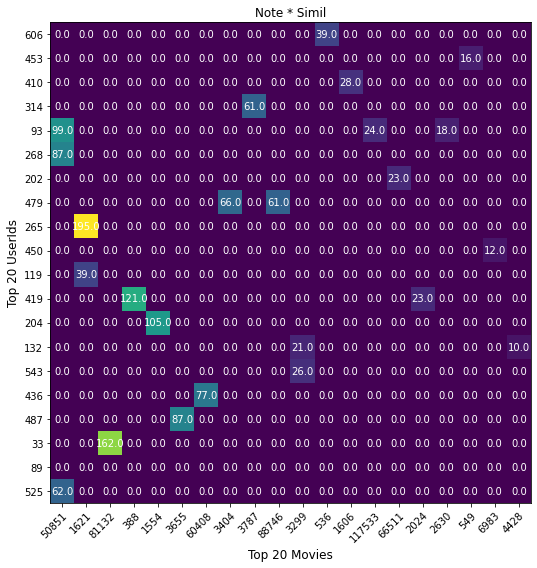

In [211]:
import matplotlib.pyplot as plt

users = top10usersId #I change it to 20
movies = top10moviesIdPlot #I change it to 20

harvest = np.array(dataToPlot)

fig, ax = plt.subplots(figsize=(8,8))
# fig.figure(figsize=(12,10))
im = ax.imshow(harvest)

# We want to show all ticks...
ax.set_xticks(np.arange(len(movies)))
ax.set_yticks(np.arange(len(users)))
# ... and label them with the respective list entries
ax.set_xticklabels(movies)
ax.set_yticklabels(users)
ax.set_xlabel('Top 20 Movies',fontsize=12)
ax.set_ylabel('Top 20 UserIds',fontsize=12)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(users)):
    for j in range(len(movies)):
        text = ax.text(j, i, harvest[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Note * Simil")
fig.tight_layout()
plt.show()

# If you are finished within the time of the lab session

### Change the following function so that it does not use filter (its effect should not change)

In [89]:
def applyFilter(myRDD,myFunction):
    return myRDD.filter(myFunction)

### Change the following function so that it does not use groupByKey (its effect should not change)

In [90]:
def grouping(myRDD):
    return myRDD.groupByKey()

### Change the following function so that it does not use distinct (its effect should not change)

In [91]:
def distinct(myRDD):
    return myRDD.distinct()

### Challenges

1 - Given a graph $G$ given as a list of pairs $x,y$ stating that there is an edge $(x,y)$,  determine the set of nodes reachable from the node $0$.

2 - Given a graph $G$ compute the distance between the node $0$ and the node $1$. 

3 - Given a graph $G$ determine whether $G$ is connex.